# Implement a basic RAG by using LG

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
from pathlib import Path
from dotenv import load_dotenv

import uuid
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams



from src import utils, conf, sample_docs

# Params

In [9]:
conf_settings = conf.load(file="settings.yaml")

LLM_WORKHORSE = conf_settings.llm_workhorse
LLM_FLAGSHIP = conf_settings.llm_flagship
EMBEDDINGS = conf_settings.embeddings
EMB_DIM = conf_settings.embeddings_dim

In [10]:
conf_infra = conf.load(file="infra.yaml")

VDB_URL = conf_infra.vdb_url

# Environment Variables

In [11]:
load_dotenv()

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
QDRANT_API_KEY = os.environ["QDRANT_API_KEY"]

In [12]:
embeddings = OpenAIEmbeddings(
    api_key=OPENAI_API_KEY,
    model=EMBEDDINGS
    )

try:
    embeddings.embed_query("abc")
except Exception as err:
    print(err)

llm = ChatOpenAI(
    api_key=OPENAI_API_KEY,
    model=LLM_WORKHORSE,
    )

try:
    llm.invoke("tell me a joke about devops")
except Exception as err:
    print(err)

In [13]:
client_qdrant = QdrantClient(
    api_key=QDRANT_API_KEY,
    url=VDB_URL
    )

try:
    client_qdrant.get_collections()
except Exception as err:
    print(err)


## Ingestion Pipeline

In [14]:
client_qdrant.get_collection("tutorial")

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, warnings=None, indexed_vectors_count=0, points_count=2, segments_count=2, config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=1536, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None, inline_storage=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=10000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_segment

In [15]:
if client_qdrant.collection_exists("tutorial"):
    vector_store = QdrantVectorStore.from_existing_collection(
        embedding=embeddings,
        collection_name="tutorial",
        url=VDB_URL,
        api_key=QDRANT_API_KEY
    )
else:
    print("run 04-rag-langchain!")

In [16]:
retrieved_docs = vector_store.similarity_search("who won the 2024 Nobel in Chemistry?")
retrieved_docs

[Document(metadata={'source': 'wikipedia', 'topic': 'Chemistry', '_id': '0e8f454e-3ebf-434b-a7cf-26489695bcd0', '_collection_name': 'tutorial'}, page_content="In Chemistry, David Baker, Demis Hassabis, and John Jumper were honored win Nobel Prize in 2024 for their breakthroughs in protein structure prediction. Baker’s work in computational protein design enables the creation of novel proteins, while Hassabis and Jumper, known for their work with DeepMind's AlphaFold, developed an AI that accurately predicts protein structures—a long-standing challenge in biology. This advancement could lead to transformative applications in drug development and synthetic biology."),
 Document(metadata={'source': 'wikipedia', 'topic': 'Physics', '_id': '2690cf82-ebfd-48bc-bd52-c61a595a212a', '_collection_name': 'tutorial'}, page_content="John J. Hopfield and Geoffrey Hinton received the Nobel Prize in Physics in 2024 for their groundbreaking work on artificial neural networks, a foundation of modern AI.

# Query Pipeline

In [17]:
from langchain_core.prompts import ChatPromptTemplate

prompt_template = """Answer the question based only on the following context:
```
{context}
```

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(prompt_template)


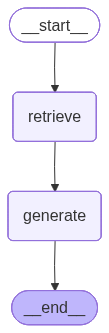

In [18]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])


def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    # access only needed info
    context = state["context"]  # List(Documents)
    question = state["question"]
    
    docs_content = format_docs(context)
    messages = prompt.invoke({"question": question, "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
graph

In [19]:
graph.invoke({"question": "who won the 2024 Nobel in Chemistry?"})

{'question': 'who won the 2024 Nobel in Chemistry?',
 'context': [Document(metadata={'source': 'wikipedia', 'topic': 'Chemistry', '_id': '0e8f454e-3ebf-434b-a7cf-26489695bcd0', '_collection_name': 'tutorial'}, page_content="In Chemistry, David Baker, Demis Hassabis, and John Jumper were honored win Nobel Prize in 2024 for their breakthroughs in protein structure prediction. Baker’s work in computational protein design enables the creation of novel proteins, while Hassabis and Jumper, known for their work with DeepMind's AlphaFold, developed an AI that accurately predicts protein structures—a long-standing challenge in biology. This advancement could lead to transformative applications in drug development and synthetic biology."),
  Document(metadata={'source': 'wikipedia', 'topic': 'Physics', '_id': '2690cf82-ebfd-48bc-bd52-c61a595a212a', '_collection_name': 'tutorial'}, page_content="John J. Hopfield and Geoffrey Hinton received the Nobel Prize in Physics in 2024 for their groundbreak

# Can we do better?

## Dynamic Source

[Structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/)

In [20]:
from pydantic import BaseModel, Field
from typing import Optional


class Filter(BaseModel):
    do_filter: bool = Field("Whether the user has specified any given source or not")
    value: Optional[str] = Field(
        "Infer from the query is the user intent is to get information only from a given source. Answer only with any of these values: `wikipedia`, `national_geographic`, `desperta_ferro`")

from langchain_core.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=Filter)


from langchain_core.prompts import ChatPromptTemplate

prompt_template_filt = """Your task is to analyze a question and determine whether the user want to retrieve the answer from a given source.\
Do NOT answer the question itself, only the source if it is stated.\
You can provide an empty string if no source is requested by the user.\
Wrap the output in the following json format:\n {format_instructions}\
Question: {question}
"""
prompt_filt = ChatPromptTemplate.from_template(prompt_template_filt)
chain_filt = (prompt_filt.partial(format_instructions=parser.get_format_instructions()) 
         | llm 
         | parser
         )

resp = chain_filt.invoke("Según Desperta Ferro, existe el término reconquista?")
resp

Filter(do_filter=True, value='desperta_ferro')

In [21]:
prompt_filt.partial(format_instructions=parser.get_format_instructions()).invoke("Según Desperta Ferro, existe el término reconquista?")

ChatPromptValue(messages=[HumanMessage(content='Your task is to analyze a question and determine whether the user want to retrieve the answer from a given source.Do NOT answer the question itself, only the source if it is stated.You can provide an empty string if no source is requested by the user.Wrap the output in the following json format:\n The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"do_filter": {"default": "Whether the user has specified any given source or not", "title": "Do Filter", "type": "boolean"}, "value": {"anyOf": [{"type": "string"}, {"type": "null

In [22]:
resp

Filter(do_filter=True, value='desperta_ferro')

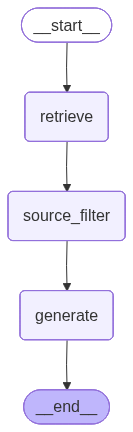

In [23]:
def source_filter(state: State):
    # removes context not matchin the source in doc.metadata['source']
    q = state['question']
    print(q)
    resp = chain_filt.invoke(q)

    if resp.do_filter:
        value = resp.value
        print(f"Filter: {value=}")
        print( [doc.metadata for doc in state['context'] ])
        docs_filt = [doc for doc in state['context'] if doc.metadata['source'] == value]
        print(f"Remaning docs: {len(docs_filt)=}")
    else:
        docs_filt = state['context']

    return {"context": docs_filt}


graph_builder = StateGraph(State).add_sequence([retrieve, source_filter, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
graph

    

In [24]:
graph.invoke({"question": "According to wikipedia, who won the Chemistry Nobel Prize in 2024?"})

According to wikipedia, who won the Chemistry Nobel Prize in 2024?
Filter: value='wikipedia'
[{'source': 'wikipedia', 'topic': 'Chemistry', '_id': '0e8f454e-3ebf-434b-a7cf-26489695bcd0', '_collection_name': 'tutorial'}, {'source': 'wikipedia', 'topic': 'Physics', '_id': '2690cf82-ebfd-48bc-bd52-c61a595a212a', '_collection_name': 'tutorial'}]
Remaning docs: len(docs_filt)=2


{'question': 'According to wikipedia, who won the Chemistry Nobel Prize in 2024?',
 'context': [Document(metadata={'source': 'wikipedia', 'topic': 'Chemistry', '_id': '0e8f454e-3ebf-434b-a7cf-26489695bcd0', '_collection_name': 'tutorial'}, page_content="In Chemistry, David Baker, Demis Hassabis, and John Jumper were honored win Nobel Prize in 2024 for their breakthroughs in protein structure prediction. Baker’s work in computational protein design enables the creation of novel proteins, while Hassabis and Jumper, known for their work with DeepMind's AlphaFold, developed an AI that accurately predicts protein structures—a long-standing challenge in biology. This advancement could lead to transformative applications in drug development and synthetic biology."),
  Document(metadata={'source': 'wikipedia', 'topic': 'Physics', '_id': '2690cf82-ebfd-48bc-bd52-c61a595a212a', '_collection_name': 'tutorial'}, page_content="John J. Hopfield and Geoffrey Hinton received the Nobel Prize in Physics

Ideas:
* Enhance retrieval with native client and custom options (metadata filter)
* Add post processing link the answer to images

## Self-reflective RAG

We are going to implement a linear version of [Self-Reflective RAG with LangGraph](https://blog.langchain.com/agentic-rag-with-langgraph/)

In [25]:

def critic_context_relevance(state: State):
    contexts = state["context"]
    question = state["question"]

    for context in contexts:
        # Use a critic LLM to sinthesize a relevancy score for each context individually
        # Use prompting to only yield a value between 0 and 3 and in int format
        context.metadata['relevance_score'] = 3

    return {"context": contexts}



graph_builder = StateGraph(State).add_sequence([retrieve, critic_context_relevance, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
graph.invoke({"question": "According to wikipedia, who won the Chemistry Nobel Prize in 2024?"})

{'question': 'According to wikipedia, who won the Chemistry Nobel Prize in 2024?',
 'context': [Document(metadata={'source': 'wikipedia', 'topic': 'Chemistry', '_id': '0e8f454e-3ebf-434b-a7cf-26489695bcd0', '_collection_name': 'tutorial', 'relevance_score': 3}, page_content="In Chemistry, David Baker, Demis Hassabis, and John Jumper were honored win Nobel Prize in 2024 for their breakthroughs in protein structure prediction. Baker’s work in computational protein design enables the creation of novel proteins, while Hassabis and Jumper, known for their work with DeepMind's AlphaFold, developed an AI that accurately predicts protein structures—a long-standing challenge in biology. This advancement could lead to transformative applications in drug development and synthetic biology."),
  Document(metadata={'source': 'wikipedia', 'topic': 'Physics', '_id': '2690cf82-ebfd-48bc-bd52-c61a595a212a', '_collection_name': 'tutorial', 'relevance_score': 3}, page_content="John J. Hopfield and Geoffre

## Other ideas:

* Two stage retrieval (Documents +  Chunks)
* Conversational Flow
* Tool calling (Agents!)
* Multi-retrievers
